### Score: `[54]`

Q1. `[5.5+5.5+5.5]` Great job!

Q2. `[11+11]` Great job!

Q3. `[5.5+10]` Good job!

各题批注用`### Note`给出，请自行查阅。

In [1]:
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

%matplotlib inline

# 1. Global methane levels from 2002

In [3]:
ds = xr.open_dataset('200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc',engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

## 1.1 Methane climatology for each month

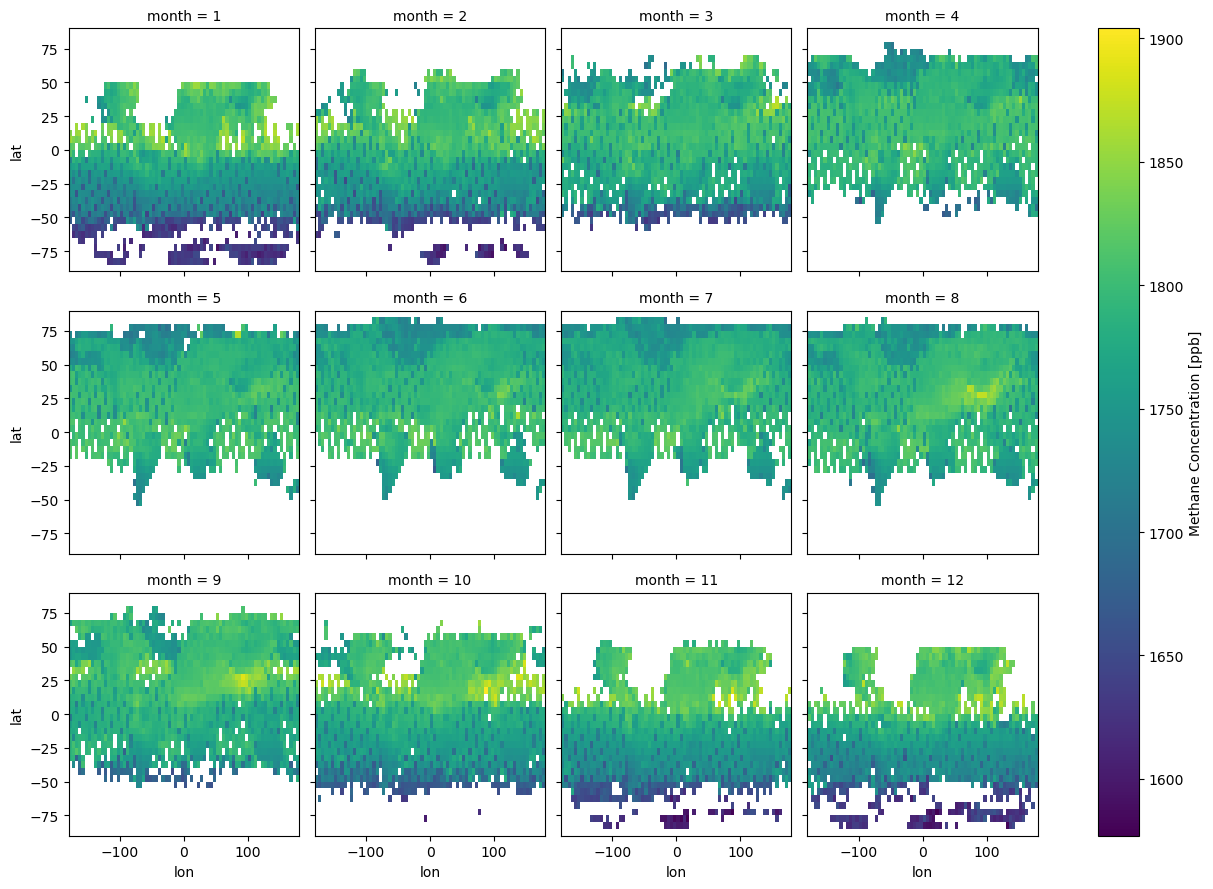

In [5]:
# *1e+9 是为了将单位转换成 ppb
(ds.xch4.groupby('time.month').mean()*1e+9).plot(col='month',col_wrap=4,
                                                cbar_kwargs={'label':'Methane Concentration [ppb]'})

plt.show()

## 1.2 Global methane concentration Time Series 

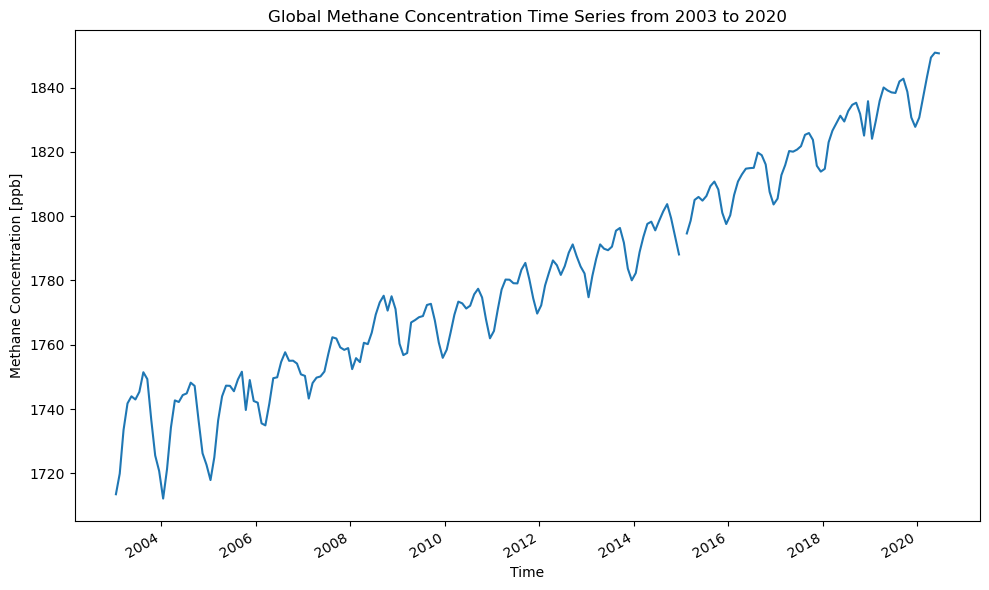

In [7]:
plt.figure(figsize=(10,6))
# 基于纬度赋予权重
weights = np.cos(np.deg2rad(ds.lat))
xch4_weighted = ds.xch4.weighted(weights)

# 计算全球的加权平均，并绘图
(xch4_weighted.mean(dim=('lon','lat')).sel(time=slice('2003-01','2020-06'))*1e+9).plot()

plt.title('Global Methane Concentration Time Series from 2003 to 2020')
plt.xlabel('Time')
plt.ylabel('Methane Concentration [ppb]')

plt.tight_layout()
plt.show()

2015年左右附近有数据值的缺失，因此线在此断开，下面将缺失值用线性插值替代并做图。

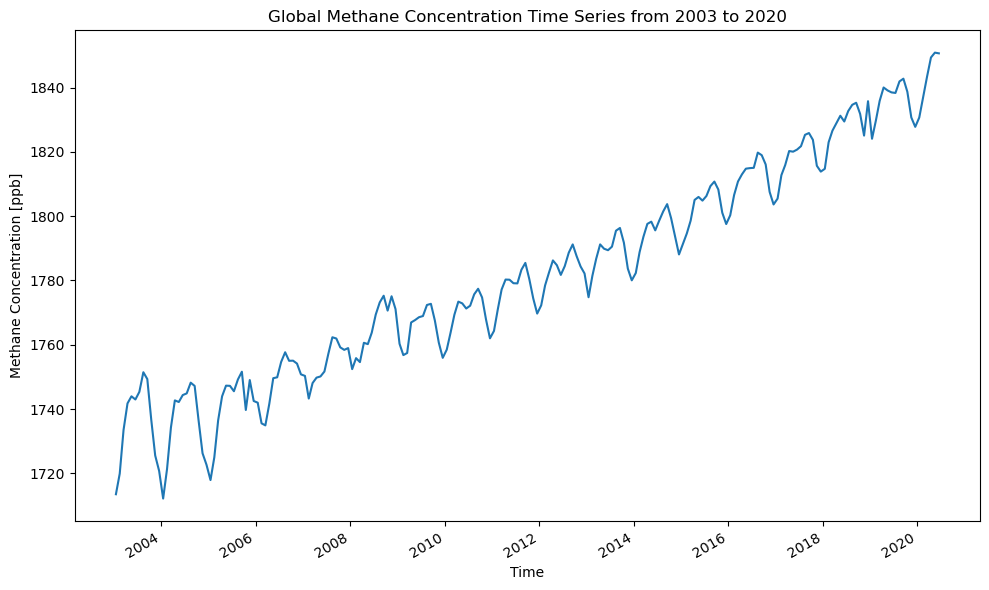

In [9]:
plt.figure(figsize=(10,6))

# 将缺失值用线性差值替代
(xch4_weighted.mean(dim=('lon','lat')).sel(time=slice('2003-01','2020-06')).interpolate_na(dim='time', method='linear')*1e+9).plot()

plt.title('Global Methane Concentration Time Series from 2003 to 2020')
plt.xlabel('Time')
plt.ylabel('Methane Concentration [ppb]')

plt.tight_layout()
plt.show()

从2003年到2020年，全球甲烷浓度呈现出明显的上升趋势，同时伴随着季节性波动。甲烷浓度在起初的三年内波动较大，2006年后呈现较稳定的增长趋势。

## 1.3 Deseasonalized methane levels

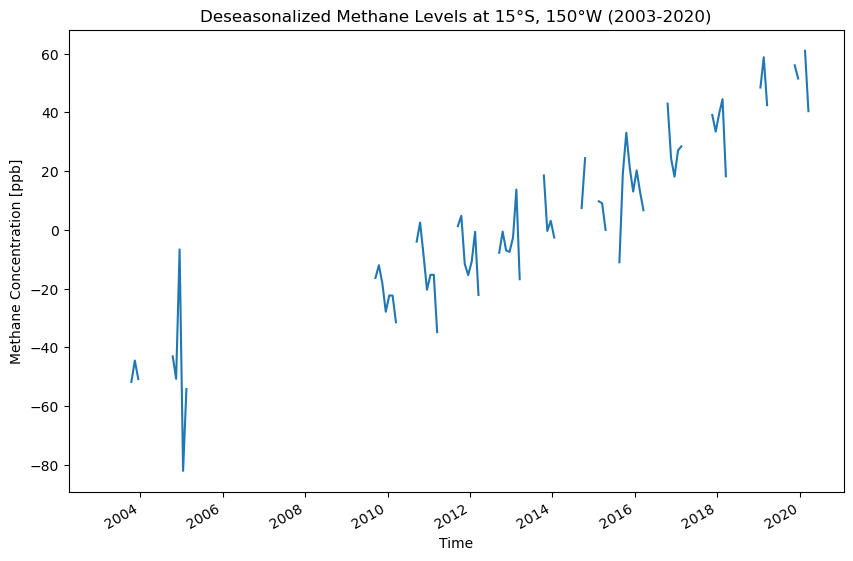

In [12]:
plt.figure(figsize=(10,6))
# 将甲烷的浓度按月分组，用该地点每个月的数据 - 对应月份的多年平均，实现 deseasonalized
group_month_xch4 = ds.xch4.sel(lon=-150,lat=-15,method='nearest').sel(time=slice('2003-01','2020-06')).groupby('time.month')
deseason_xch4 = (group_month_xch4 - group_month_xch4.mean())*1e+9
deseason_xch4.plot()

plt.title('Deseasonalized Methane Levels at 15°S, 150°W (2003-2020)')
plt.xlabel('Time')
plt.ylabel('Methane Concentration [ppb]')

plt.show()

该地点的数据值缺失较多，连接多处断开。下面将其缺失值删掉，并重新绘制图。

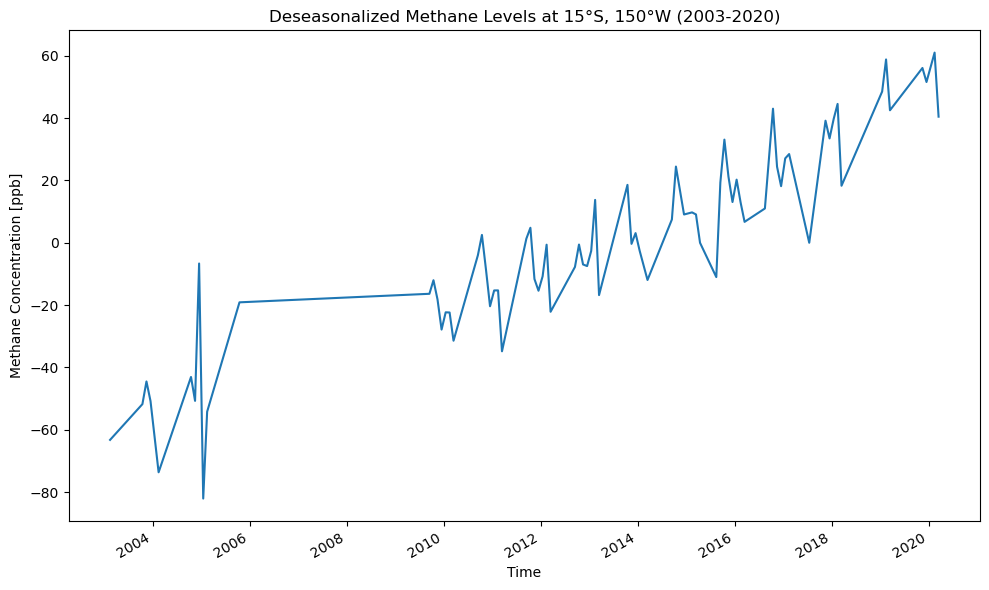

In [14]:
plt.figure(figsize=(10,6))
group_month_xch4 = ds.xch4.sel(lon=-150,lat=-15,method='nearest').sel(time=slice('2003-01','2020-06')).dropna(dim='time').groupby('time.month')
deseason_xch4 = (group_month_xch4 - group_month_xch4.mean())*1e+9
deseason_xch4.plot()

plt.title('Deseasonalized Methane Levels at 15°S, 150°W (2003-2020)')
plt.xlabel('Time')
plt.ylabel('Methane Concentration [ppb]')

plt.tight_layout()
plt.show()

该地点2010年前的数据缺失较多，2010 ~ 2020年期间的甲烷浓度整体上呈现出明显的上升趋势。

# 2. Niño 3.4 index

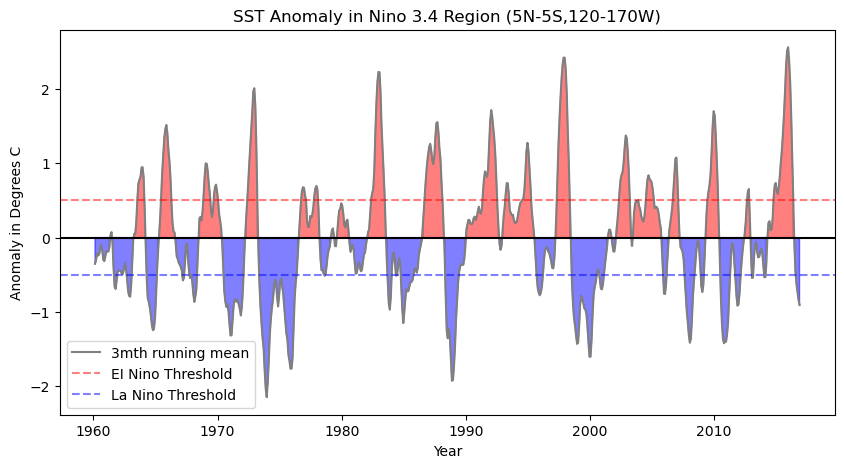

In [17]:
# 2.1 Compute monthly climatology and anomalies
ds = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc',engine='netcdf4')

## 选择Nino区域包含的数据，计算这个区域上的加权平均
nino_sst = ds.sst.sel(lat=slice(-5,5),lon=slice(10+180,60+180))
weights = np.cos(np.deg2rad(nino_sst.lat))
nino_sst_weighted = nino_sst.weighted(weights).mean(dim=('lat','lon')) 

## 将数据按月分组，并差减月份气候态得到异常值
group_month_sst = nino_sst_weighted.groupby('time.month')
nino_sst_anom = group_month_sst - group_month_sst.mean()

# 2.2 Visualize
## 计算连续3个月滑动平均值
nino_sst_anom_3m = nino_sst_anom.rolling(time=3, center=True).mean()

## 绘图
plt.figure(figsize=(10,5))
plt.plot(nino_sst_anom_3m.time, nino_sst_anom_3m, color='grey', label='3mth running mean')
## 填充正负异常值区域
plt.fill_between(nino_sst_anom_3m.time, nino_sst_anom_3m, where=(nino_sst_anom_3m > 0), color='red', alpha=0.5)
plt.fill_between(nino_sst_anom_3m.time, nino_sst_anom_3m, where=(nino_sst_anom_3m < 0), color='blue', alpha=0.5)
## 添加辅助线
plt.axhline(0, color='black', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='EI Nino Threshold')
plt.axhline(-0.5, color='blue', linestyle='--', alpha=0.5, label='La Nino Threshold')

plt.title('SST Anomaly in Nino 3.4 Region (5N-5S,120-170W)')
plt.xlabel('Year')
plt.ylabel('Anomaly in Degrees C')
plt.legend(loc='best')

plt.show()

# 3 Explore a netCDF dataset

所用数据为助教在群中发的
https://send.cra.moe/file/X65CzgqXopAroKkF/zcji1e1QWeR4xNB9/S3%E4%BD%9C%E4%B8%9A%E6%95%B0%E6%8D%AE.zip

In [20]:
# 将所有netcdf4数据文件读取并合并
ds = xr.open_mfdataset('oco2_GEOS_L3CO2_month_*.nc4')
ds

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576, time: 86)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2015-01-16T12:00:00 ... 2022-02-15
Data variables:
    XCO2      (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    XCO2PREC  (time, lat, lon) float64 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
Attributes: (12/25)
    RangeBeginningDate:             2017-08-01
    RangeBeginningTime:             00:00:00.000000
    RangeEndingDate:                2017-08-01
    RangeEndingTime:                23:59:99.999999
    SpatialCoverage:                global
    SouthBoundingCoordinate:        -90.0
    ...                             ...
    ProductionDateTime:             2022-03-15T12:04:33Z
    History:                        Original file generated: Tue Mar 15 12:04...
    ShortName:                      OCO2_GEOS_L3CO2_MONTH_10r
    LongName:                       OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    Title:                          OCO-2 GEOS Level 3 monthly, 0.5x0.625 ass...
    IdentifierProductDOI:           10.5067/BGFIODET3HZ8

## 3.1 Plot a time series

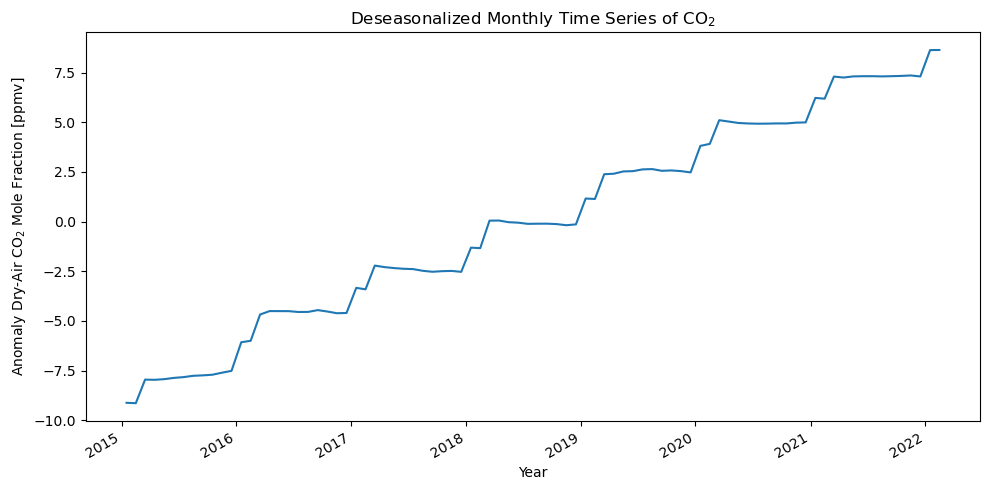

In [22]:
# 基于纬度赋予权重
weights = np.cos(np.deg2rad(ds.XCO2.lat))
XCO2_weighted = ds.XCO2.weighted(weights)


# 计算纬度加权平均并按月分组，去除季节化
group_monthly = XCO2_weighted.mean(dim=('lon','lat')).groupby('time.month')
remove_seasonal = (group_monthly - group_monthly.mean())*1e+6

# 绘图
plt.figure(figsize=(10,5))
remove_seasonal.plot()

plt.title('Deseasonalized Monthly Time Series of CO$_2$')
plt.xlabel('Year')
plt.ylabel('Anomaly Dry-Air CO$_2$ Mole Fraction [ppmv]')

plt.tight_layout()
plt.show()

## 3.2 

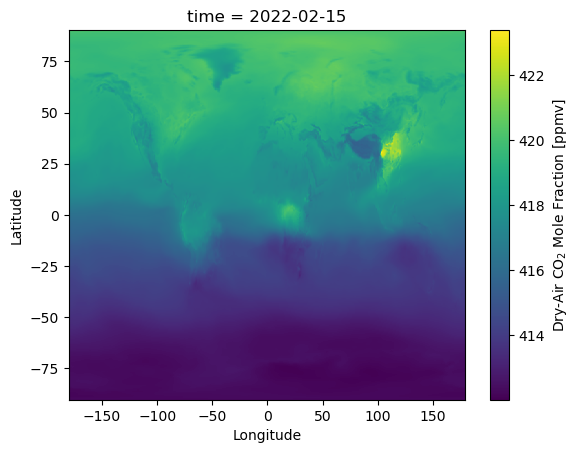

In [24]:
# 绘制最近月份的CO2浓度2-D figure
(ds.XCO2[-1]*1e+6).plot(cbar_kwargs={'label':'Dry-Air CO$_2$ Mole Fraction [ppmv]'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

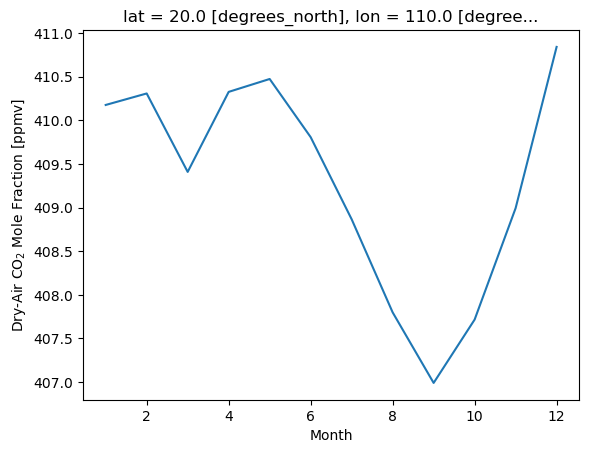

In [25]:
# 绘制海口市的CO2气候态
(ds.XCO2.sel(lon=110,lat=20,method='nearest').groupby('time.month').mean()*1e+6).plot()
plt.xlabel('Month')
plt.ylabel('Dry-Air CO$_2$ Mole Fraction [ppmv]')
plt.show()

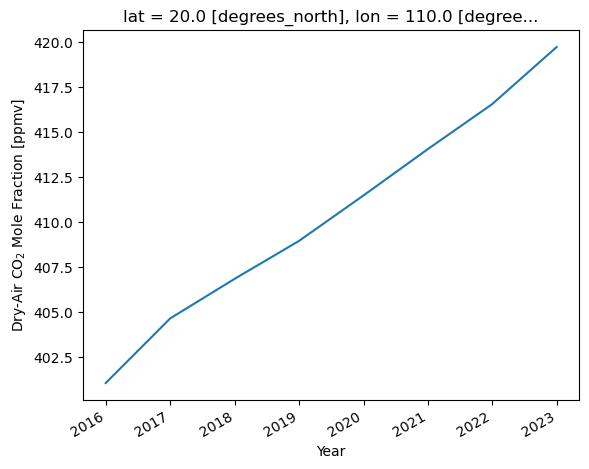

In [26]:
# 绘制海口市的多年来CO2的变化情况(连续一年平均)
(ds.XCO2.sel(lon=110,lat=20,method='nearest').resample(time='1YE').mean()*1e+6).plot()
plt.xlabel('Year')
plt.ylabel('Dry-Air CO$_2$ Mole Fraction [ppmv]')
plt.show()

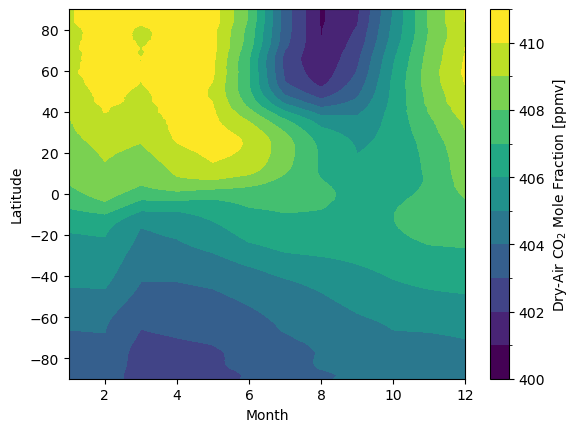

In [27]:
# Plot zonal mean climatology
(ds.XCO2.groupby('time.month').mean().mean(dim='lon')*1e+6).plot.contourf(x='month', levels=12,cbar_kwargs={'label':'Dry-Air CO$_2$ Mole Fraction [ppmv]'})
plt.xlabel('Month')
plt.ylabel('Latitude')
plt.show()

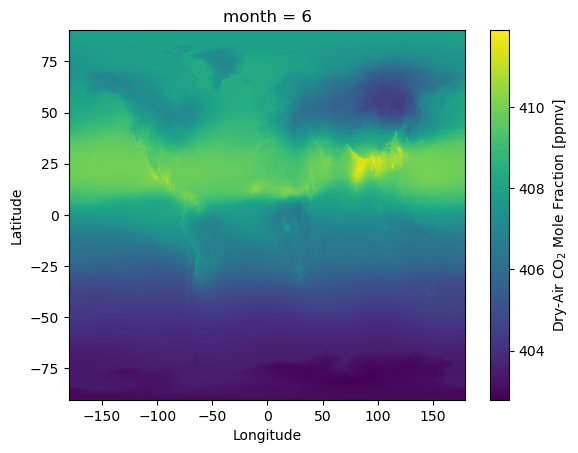

In [28]:
# 绘制六月份全球的CO2格局
(ds.XCO2.groupby('time.month').mean()*1e+6)[5,:,:].plot(cbar_kwargs={'label':'Dry-Air CO$_2$ Mole Fraction [ppmv]'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()